# Finite difference method: Convection diffusion equation in 2D with Neumann boundary conditions

Consider the convection diffusion equation 
$$
- \epsilon \Delta u + \frac{\partial u}{\partial x} = f \quad \text{in } \Omega = (0,1)^2 \; ,
$$
with the boundary conditions
$$
\begin{aligned}
u(x,0) &= 0, &\; u(x, 1) &= 0 \quad \text{for } x \in [0, 1] \; ,\\
\frac{\partial u}{\partial n}(0, y) &= 0, &\; \frac{\partial u}{\partial n}(1, y) &= 0 \quad \text{for } y \in (0, 1) \; .
\end{aligned}
$$

The Laplace operator should be approximated by the five-point stencil. To discretize $\frac{\partial u}{\partial x}$ use backwards difference quotients. To discretize the Neumann boundary conditions use central difference quotients.

As a test problem, use 
$$
f(x,y)
= 
\begin{cases}
\sqrt{0.1^2 - (x-0.3)^2 - (y-0.2)^2} \; , & (x-0.3)^2 + (y-0.2)^2 < 0.1^2 \\
0 \; , & \text{else}
\end{cases}
$$

For $\epsilon = 1, \frac{1}{10}, \frac{1}{100}$ calculate and plot the numerical solution on an equidistant grid with mesh size $h = 2^{-6}$.




## Solution

First let's find out, how many inner points we need to use:

In [1]:
epsilons = [1, 0.1, 0.01]
h = 1/(2^6)
N = convert(Int, floor(1/h - 1))

63

In [2]:
f(x,y) = (v = (0.1^2 - (x-0.3)^2 - (y-0.2)^2)) > 0 ? sqrt(v) : 0;

We get the following discretization:
$$
\begin{aligned}
(4\epsilon + h) u_{i,j} + (-h-\epsilon) u_{i-1, j} - \epsilon u_{i+1, j} - \epsilon u_{i,j+1} - \epsilon u_{i,j-1} &= h^2 f_{i,j} \; , \quad &\text{for } i=2,\ldots, N \; , j=2, \ldots, N \\
u_{i,0} &= 0 \; , \quad &\text{for } i=1, \ldots, N+1 \\
u_{i, N+1} &= 0 \; , \quad &\text{for } i=1, \ldots, N+1 \\
(4\epsilon + h) u_{0,j} + (-h-2\epsilon) u_{1,j} - \epsilon u_{0, j+1} - \epsilon u_{0,j-1} &= h^2 f_{i,j} \; , \quad &\text{for } i=0, \; j=2, \ldots, N \\
(4\epsilon + h) u_{N+1,j}  +(-h - 2\epsilon) u_{N,j} - \epsilon u_{N+1,j+1} - \epsilon u_{N+1, j-1} &= h^2 f_{i,j} \; , \quad &\text{for } i=N+1, \; j=2, \ldots, N
\end{aligned}
$$

We write a function to solve this scheme.

In [3]:
using SparseArrays
function solve(n, f, epsilon)
    x = range(0, stop=1, length=n+2)
    y = range(0, stop=1, length=n+2)
    f_vec = reshape([f(xi, yi) for xi=x, yi=y], :)
    f_vec[1:n+2] .= 0
    f_vec[(n+2)^2 - n - 1 : (n+2)^2] .= 0
    
    h = 1 / (n+1)
    tot = (n+2)^2
    
    mdiag = (4epsilon + h)ones(tot)
    mdiag[1:n+2] = mdiag[tot - n - 1:tot] .= 1
    
    udiag = -epsilon * ones(tot)
    udiag[1:n+2] = udiag[tot - n - 1:tot] .= 0
    udiag[n+3:n+2:tot-n-2] .= -h - 2epsilon
    udiag[2n+4:n+2:tot-n-2] .= 0
    
    ldiag = (-h - epsilon) * ones(tot)
    ldiag[1:n+2] = ldiag[tot - n - 1:tot] .= 0
    ldiag[n+3:n+2:tot-n-2] .= 0
    ldiag[2n+4:n+2:tot-n-2] .= -h - 2epsilon
    
    uudiag = -epsilon * ones(tot)
    uudiag[1:n+2] .= 0
    
    lldiag = -epsilon * ones(tot)
    lldiag[tot - n - 1:tot] .= 0
    
    pop!(udiag)
    popfirst!(ldiag)
    for i=1:n+2
        pop!(uudiag)
        popfirst!(lldiag)
    end
    
    #M = spdiagm((lldiag, ldiag, mdiag, udiag, uudiag), (-n-2, -1, 0, 1, n+2))
    M = spdiagm(-n-2 => lldiag, -1 => ldiag, 0 => mdiag, 1 => udiag, n+2 => uudiag)
    rhs = h^2 * f_vec
    M \ rhs

end
;

Now we use this function to calculate the numerical solutions for the three different $\epsilon$.

In [4]:
numerical_solutions = [solve(N, f, x) for x in epsilons];

Now we write functions to visualize these solutions.

In [5]:
using PyPlot
PyPlot.using3D()
function plot_3d(numsol, epsilon)
    n = convert(Int, floor(sqrt(length(numsol))) - 2)
    x = range(0, stop=1, length=n+2)
    y = range(0, stop=1, length=n+2)

    xgrid = repeat(x', n+2 ,1)
    ygrid = repeat(y, 1, n+2)
    znum = reshape(numsol, n+2, n+2)'
    
    fig = figure("pyplot_surfaceplot",figsize=(10,10))
    suptitle(string("Numerical solution for ϵ = ", epsilon))
    ax = fig.add_subplot(2,1,1, projection = "3d")
    ax.plot_surface(xgrid, ygrid, znum, rstride=2,edgecolors="k", cstride=2, cmap=ColorMap("jet"), alpha=0.8, linewidth=0.25)
    xlabel("x")
    ylabel("y")
    
    ax = fig.add_subplot(2,1,2, aspect="equal")
    cp = ax.contour(xgrid, ygrid, znum, colors="black", linewidth=2.0)
    ax.clabel(cp, inline=1, fontsize=10)
    #ax[:axis]("equal")
    xlabel("x")
    ylabel("y")
end
;

We know use this function to visualize the numerical results for $\epsilon = 1, 0.1, 0.01$.

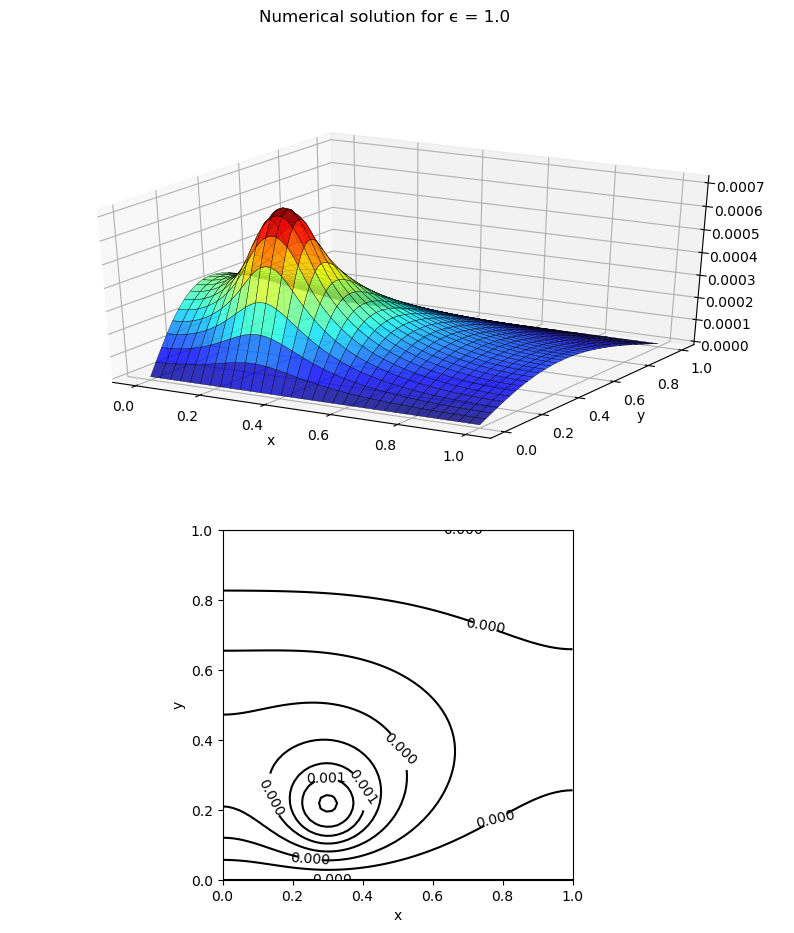

In [6]:
plot_3d(numerical_solutions[1], epsilons[1]);

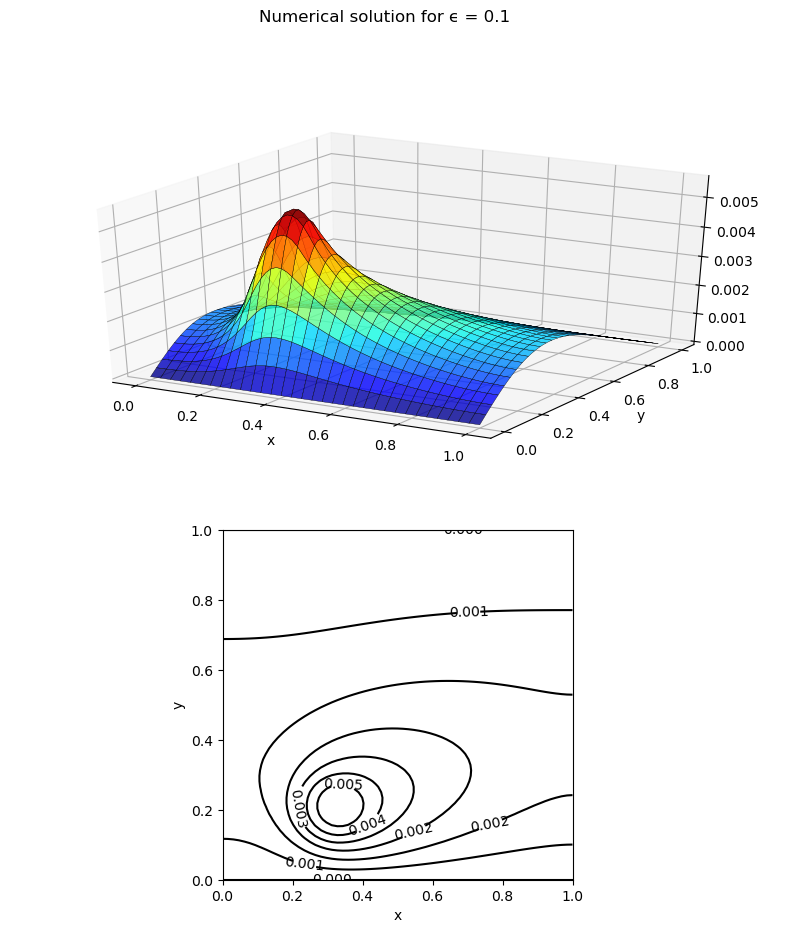

In [7]:
plot_3d(numerical_solutions[2], epsilons[2]);

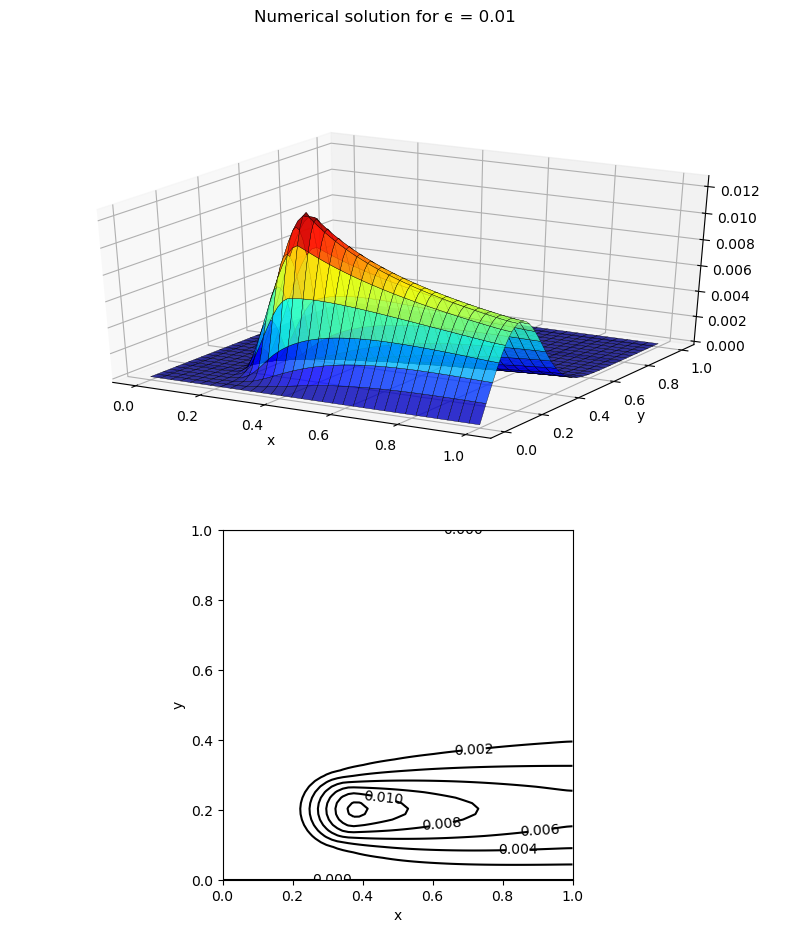

In [8]:
plot_3d(numerical_solutions[3], epsilons[3]);